In [1]:
!sudo apt install -y libsndfile1
!pip install numba==0.48
!pip install git+https://github.com/fastaudio/fastaudio.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
  Cloning https://github.com/fastaudio/fastaudio.git to /tmp/pip-req-build-6sf3qddr
  Running command git clone -q https://github.com/fastaudio/fastaudio.git /tmp/pip-req-build-6sf3qddr
     |████████████████████████████████| 194kB 8.4MB/s 
     |████████████████████████████████| 7.6MB 25.9MB/s 
     |████████████████████████████████| 184kB 54.7MB/s 
     |████████████████████████████████| 788kB 38.3MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 358kB 48.3MB/s 
  Created wheel for fastaudio: filename=fastaudio-0.1.4.post0.dev2+g8631a3f-py2.py3-none-any.whl size=18329 sha256=2698516434aa09f24470ff32fba6abaed8b9dfcdc36b6148677ebe5c68d32dc6
  Stored in direct

In [ ]:
!pip install timm
!pip install efficientnet_pytorch

     |████████████████████████████████| 245kB 13.1MB/s 


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchaudio
torchaudio.set_audio_backend("sox_io")
import torchaudio

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append("..")

import librosa as lr
import librosa.display

import soundfile as sf
import io

from pathlib import Path
from tqdm.notebook import tqdm

from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *

import fastai
fastai.__version__

'2.1.8'

In [4]:
from google.colab import drive
drive.mount('/content/drive')# You must grant COLAB access to your Google Drive

Mounted at /content/drive


In [ ]:
DATA_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data")
AUDIO_ROOT = Path(DATA_ROOT/"train/")
TRAIN_AUDIO_ROOT = Path(DATA_ROOT/"samples_long")
TEST_AUDIO_ROOT = Path(DATA_ROOT/"test")
VAL_AUDIO_ROOT = Path(DATA_ROOT/"val")
df_train = pd.DataFrame([path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")], columns=["recording_id"])
df_test = pd.DataFrame([path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")], columns=["recording_id"])
df = pd.read_csv(Path(DATA_ROOT/"train_tp.csv"))
print(df_train.shape, df_test.shape)
df

# Define multi class model

In [ ]:
def get_y_fn(x):
  y = str(x).split(".")[0].split('_')[-2]
  return y


cfg = AudioConfig.BasicMelSpectrogram(
        f_min=df["f_min"].min(),
        f_max=df["f_max"].max(),
        n_fft=1024,
        n_mels=384,
        hop_length=400
   )

cfg_2 = AudioConfig.BasicMelSpectrogram(
        f_min=df["f_min"].min()-5,
        f_max=df["f_max"].max()+5,
        n_fft=1024,
        n_mels=448,
        hop_length=400
   )

cfg_3 = AudioConfig.BasicMelSpectrogram(
        f_min=df["f_min"].min()-5,
        f_max=df["f_max"].max()+5,
        n_fft=1024,
        n_mels=448,
        hop_length=300
   )

## Calculate mean and std

In [ ]:
class StatsRecorder:
    def __init__(self, red_dims=(0,2,3)):
        """Accumulates normalization statistics across mini-batches.
        ref: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """
        self.red_dims = red_dims # which mini-batch dimensions to average over
        self.nobservations = 0   # running number of observations

    def update(self, data):
        """
        data: ndarray, shape (nobservations, ndimensions)
        """
        # initialize stats and dimensions on first batch
        print(data.shape)
        if self.nobservations == 0:
            self.mean = data.mean(dim=self.red_dims, keepdim=True)
            self.std  = data.std (dim=self.red_dims,keepdim=True)
            self.nobservations = data.shape[0]
            self.ndimensions   = data.shape[1]
        else:
            # if data.shape[1] != self.ndimensions:
            #     raise ValueError('Data dims do not match previous observations.')
            
            # find mean of new mini batch
            newmean = data.mean(dim=self.red_dims, keepdim=True)
            newstd  = data.std(dim=self.red_dims, keepdim=True)
            
            # update number of observations
            m = self.nobservations * 1.0
            n = data.shape[0]

            # update running statistics
            tmp = self.mean
            self.mean = m/(m+n)*tmp + n/(m+n)*newmean
            self.std  = m/(m+n)*self.std**2 + n/(m+n)*newstd**2 +\
                        m*n/(m+n)**2 * (tmp - newmean)**2
            self.std  = torch.sqrt(self.std)
                                 
            # update total number of seen samples
            self.nobservations += n



auds_simple = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 #get_x = ColReader("recording_id", pref=TRAIN_AUDIO_ROOT, suff=".flac"), 
                 get_items=get_audio_files,
                 item_tfms = [Resample(28000),ResizeSignal(8000, pad_mode=AudioPadType.Repeat) ],
                 splitter = RandomSplitter(),
                 #batch_tfms = [a2s],
                 #get_y = ColReader("species_id"), 
                 get_y=get_y_fn,
                 batch_tfms =  [AudioToSpec.from_cfg(cfg),]
                )

print(auds_simple.summary(TRAIN_AUDIO_ROOT))



# create recorders
channel_stats = StatsRecorder(red_dims=(0,1,3))

# step through the training dataset
with torch.no_grad():
    for idx,(x,y) in enumerate(auds_simple.dataloaders(TRAIN_AUDIO_ROOT).train):
        # update normalization statistics
        #global_stats.update(x)
        channel_stats.update(x)
    
# parse out both sets of stats
channel_mean,channel_std = channel_stats.mean,channel_stats.std

ch_mean = channel_mean.cpu().mean(axis=0, keepdim=True).mean(axis=3, keepdim=True)
ch_std = channel_std.cpu().mean(axis=0, keepdim=True).mean(axis=3, keepdim=True)

ChannelSpecNorm = SpecNormalize(ch_mean, ch_std, axes=(0))

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (384) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


Setting-up type transforms pipelines
Found 1166 items
2 datasets of sizes 933,233
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> RegressionSetup -- {'c': None}

Building one sample
  Pipeline: partial
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/b6ddaa9b4_4.flac
    applying partial gives
      AudioTensor of size 1x61696
  Pipeline: get_y_fn -> RegressionSetup -- {'c': None}
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/b6ddaa9b4_4.flac
    applying get_y_fn gives
      0.4
    applying RegressionSetup -- {'c': None} gives
      tensor(0.4000)

Final sample: (AudioTensor([[-0.0042, -0.0014, -0.0046,  ...,  0.0465,  0.0261,  0.0069]]), tensor(0.4000))


Found 1166 items
2 datasets of sizes 933,233
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> RegressionSetup -- {'c': None}
Setting up after_item: Pipeline: Resample -> DownmixMono -> ResizeSignal -> ToTensor
Setting

NameError: ignored

In [ ]:
np.save("channel_std", ch_std.cpu().numpy(), allow_pickle=True)
np.save("channel_mean", ch_mean.cpu().numpy(), allow_pickle=True)

In [ ]:
ch_std = torch.Tensor(np.load(Path(DATA_ROOT/"../channel_std.npy"),  allow_pickle=True))
ch_mean = torch.Tensor(np.load(Path(DATA_ROOT/"../channel_mean.npy"), allow_pickle=True))

## Define db and dls

In [ ]:
#ChannelSpecNorm = SpecNormalize(ch_mean, ch_std, axes=(0))

item_tfms = [Resample(28000),ResizeSignal(8000, pad_mode=AudioPadType.Repeat), 
           #AddNoise(noise_level=0.3),
           ]
batch_tfms = [ AudioToSpec.from_cfg(cfg), 
              SGRoll(),
              MaskFreq(), MaskTime(), 
              Normalize(ch_mean, ch_std, axes=(0, 1, 3)),
              ]

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 #get_x = ColReader("recording_id", pref=TRAIN_AUDIO_ROOT, suff=".flac"), 
                 get_items=get_audio_files,
                 item_tfms = item_tfms,
                 splitter = RandomSplitter(),
                 #batch_tfms = [a2s],
                 #get_y = ColReader("species_id"), 
                 get_y=get_y_fn,
                 batch_tfms = batch_tfms
                                  )
print(auds.summary(TRAIN_AUDIO_ROOT))
dls = auds.dataloaders(TRAIN_AUDIO_ROOT, bs=32, verbose=True, before_batch = batch_tfms, 
                       num_workers=4
                       #, shuffle=True
                      )
#dls.show_batch()

#вот тут развить мысль про аугментации

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (384) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


Setting-up type transforms pipelines
Found 1216 items
2 datasets of sizes 973,243
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples_long/4b406a1bc_4_361.flac
    applying partial gives
      AudioTensor of size 1x252000
  Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples_long/4b406a1bc_4_361.flac
    applying get_y_fn gives
      4
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(18)

Final sample: (AudioTensor([[-0.0804, -0.0815, -0.0527,  ...,  0.0035,  0.0220,  0.0460]]), TensorCategory(18))


Found 1216 items
2 datasets of sizes 973,243
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> Categori

In [ ]:
def _one_sample_positive_class_precisions(scores, truth):
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)

    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)

    retrieved_classes = np.argsort(scores)[::-1]

    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)

    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True

    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)

    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits

def lwlrap(scores, truth):
    #print(truth.shape, scores.shape)
    num_samples, num_classes = scores.shape
    scores = scores.cpu().numpy()
    gt = np.zeros((num_samples, num_classes))
    for n, i in enumerate(truth.cpu().numpy().astype(int)):
      gt[n, i] = 1
    assert gt.shape == scores.shape
    
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], gt[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits

    labels_per_class = np.sum(gt > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    #return per_class_lwlrap, weight_per_class
    return (per_class_lwlrap * weight_per_class).sum()


In [ ]:
from efficientnet_pytorch import EfficientNet
from timm import create_model
# from https://colab.research.google.com/github/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/05_EfficientNet_and_Custom_Weights.ipynb#scrollTo=VXPjDVUlJgCU

In [ ]:
def create_timm_body(arch:str, pretrained=True, cut=None):
  model = create_model(arch, pretrained=pretrained, in_chans=1)
  if cut is None:
    ll = list(enumerate(model.children()))
    cut = next(i for i,o in reversed(ll) if has_pool_type(o))
  if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
  elif callable(cut): return cut(model)
  else: raise NamedError("cut must be either integer or function")
body = create_timm_body('efficientnet_b3', pretrained=True)

head = create_head(num_features_model(nn.Sequential(*body.children())) * (2), dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)
len(model)

2

In [ ]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identit

In [ ]:
learn = Learner(dls, 
            model,
           # n_in=1, #<- Only audio specific modification here
        #    loss_func=LabelSmoothingCrossEntropyFlat(),
            splitter=default_split,
        #    cbs = OutputMixup(alpha=0.4),
            metrics=[accuracy, lwlrap],
            train_bn=False)
learn.to_fp16()
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

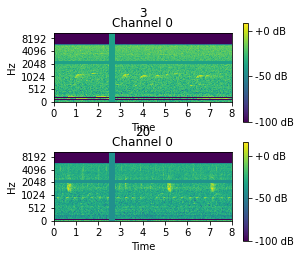

In [ ]:
dls.show_batch()

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0014454397605732083)

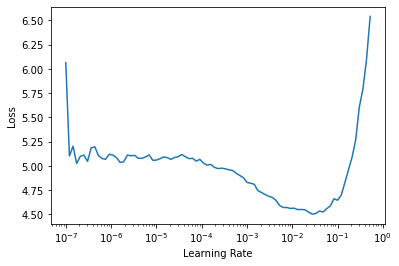

In [ ]:
learn.lr_find()

In [ ]:
EXP_NAME = "b3"
SUFFIX ="step1"
#learn.fit_one_cycle(6, 1e-3)
learn.freeze()
learn.fit_flat_cos(2)
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3,   wd=1e-2, div=10, pct_start=0.3,
                    cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}') ]
)
                    
#learn.fit_one_cycle(5,  1e-3/5, wd=1e-2, div=10, pct_start=0.3)
#learn.fit_one_cycle(30, 1e-3/8, wd=1e-2, div=10, pct_start=0.3)

Better model found at epoch 0 with valid_loss value: 2.6369450092315674.
Better model found at epoch 1 with valid_loss value: 2.1819028854370117.
Better model found at epoch 2 with valid_loss value: 1.879639744758606.
Better model found at epoch 3 with valid_loss value: 1.7098037004470825.
Better model found at epoch 4 with valid_loss value: 1.3878850936889648.
Better model found at epoch 5 with valid_loss value: 1.349814534187317.
Better model found at epoch 6 with valid_loss value: 1.1177276372909546.
Better model found at epoch 7 with valid_loss value: 1.0693057775497437.
Better model found at epoch 9 with valid_loss value: 0.9397616982460022.


In [ ]:
EXP_NAME = "b3"
SUFFIX ="step2"
learn.load("b3_step1")
learn.fit_one_cycle(10,  1e-3/5, wd=1e-2, div=10, pct_start=0.3,
                    cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}')]
                    )

Better model found at epoch 0 with valid_loss value: 0.955182671546936.
Better model found at epoch 1 with valid_loss value: 0.9100977182388306.
Better model found at epoch 2 with valid_loss value: 0.8515635132789612.
Better model found at epoch 3 with valid_loss value: 0.7894947528839111.


In [ ]:
SUFFIX ="step3"
learn.load("b3_step2")
learn.to_fp16()
learn.fit_one_cycle(20, 1e-3/8, wd=1e-2, div=10, pct_start=0.3,
                    cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}')]
                    )

Better model found at epoch 0 with valid_loss value: 1.0415823459625244.
Better model found at epoch 1 with valid_loss value: 0.9347026944160461.
Better model found at epoch 3 with valid_loss value: 0.9171893000602722.
Better model found at epoch 11 with valid_loss value: 0.8160142302513123.


In [ ]:
item_tfms = [Resample(42000),ResizeSignal(8000, pad_mode=AudioPadType.Repeat), 
           #AddNoise(noise_level=0.3),
           #  AudioNormalize
           ]
batch_tfms = [ AudioToSpec.from_cfg(cfg_2), 
       
              SGRoll(),
              #MaskFreq(), MaskTime(), 
     #         Normalize(ch_mean, ch_std, axes=(0, 1, 3)),
              ]

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 #get_x = ColReader("recording_id", pref=TRAIN_AUDIO_ROOT, suff=".flac"), 
                 get_items=get_audio_files,
                 item_tfms = item_tfms,
                 splitter = RandomSplitter(),
                 #batch_tfms = [a2s],
                 #get_y = ColReader("species_id"), 
                 get_y=get_y_fn,
                 batch_tfms = batch_tfms
                                  )
print(auds.summary(TRAIN_AUDIO_ROOT))
dls = auds.dataloaders(TRAIN_AUDIO_ROOT, bs=16, verbose=True, before_batch = batch_tfms, 
                       num_workers=4
                       #, shuffle=True
                      )

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (448) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


Setting-up type transforms pipelines
Found 1166 items
2 datasets of sizes 933,233
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/7b287d190_20.flac
    applying partial gives
      AudioTensor of size 1x118101
  Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples/7b287d190_20.flac
    applying get_y_fn gives
      20
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(13)

Final sample: (AudioTensor([[ 9.9063e-04, -1.2250e-03, -6.9976e-05,  ..., -6.7115e-04,
         -1.6478e-03, -3.8054e-03]]), TensorCategory(13))


Found 1166 items
2 datasets of sizes 933,233
Setting up Pipeline: partial
Setting up Pipeline: ge

In [ ]:
SUFFIX ="step4"
learn = Learner(dls, 
            model,
           # n_in=1, #<- Only audio specific modification here
        #    loss_func=LabelSmoothingCrossEntropyFlat(),
            splitter=default_split,
        #    cbs = OutputMixup(alpha=0.4),
            metrics=[accuracy])
learn.load("b1_wo_masks_step3")
learn.to_fp16()

learn.fit_one_cycle(5, 1e-3/4, wd=1e-3, div=10, pct_start=0.3,
                    cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}')]
                    )

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:55: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Better model found at epoch 0 with valid_loss value: 0.2308095395565033.
Better model found at epoch 2 with valid_loss value: 0.16400198638439178.


In [ ]:
learn.load("b1_wo_masks_step4")

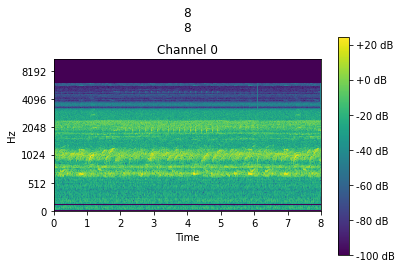

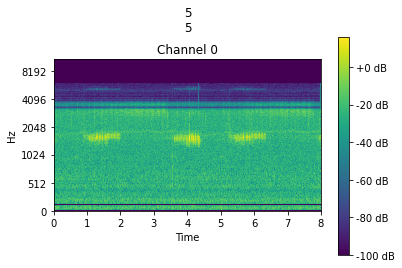

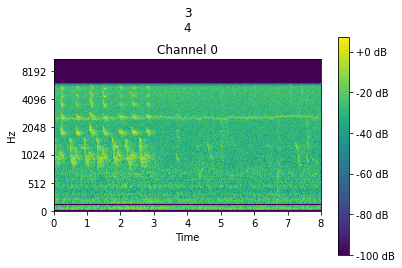

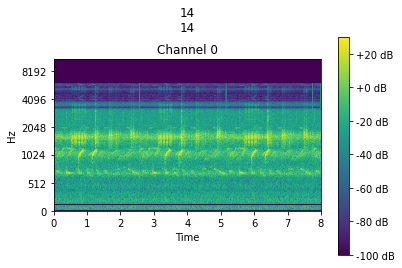

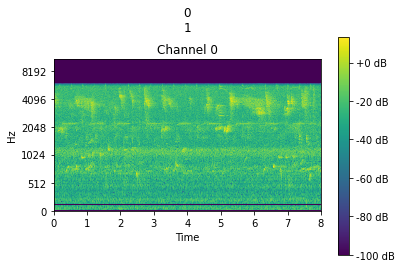

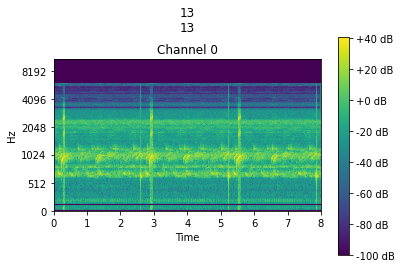

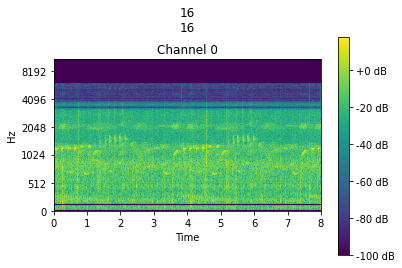

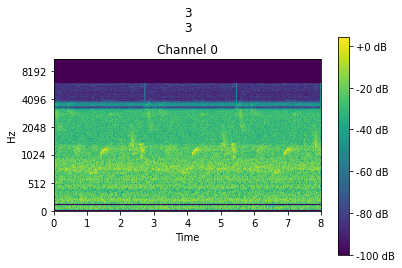

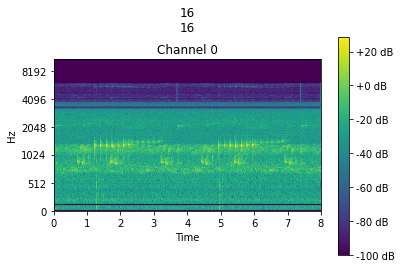

In [ ]:
learn.show_results()

## save load models

In [ ]:
learn.save("effb3_18_1")

Path('models/effb3_18_1.pth')

In [ ]:
#!cp models/* drive/MyDrive/
!cp drive/MyDrive/rn50_26_2.pth models

In [ ]:
#learn.load("rn50_26_2")
learn.fit_one_cycle(20, 5e-3 )

In [ ]:
!tar -czf  2_class_pred.tar 2_class_pred.csv

tar: 2_class_pred.csv: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [ ]:
!cp2_class_pred.tar drive/MyDrive/

/bin/bash: cp2_class_pred.tar: command not found


## confusion matrix

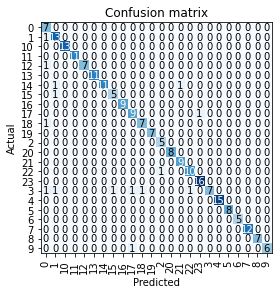

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

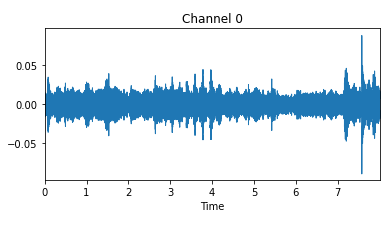

In [ ]:
SR = 28000
speakers = get_audio_files(VAL_AUDIO_ROOT)
speakers[1]
audio = AudioTensor.create(speakers[7])
audio.show()

In [ ]:
y, sr = torchaudio.load("/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/val/003bec244_1.flac")
print("Sample rate  :", sr)
print("Signal Length:", len(y))
print("Duration     :", len(y)/sr, "seconds")

Sample rate  : 28000
Signal Length: 1
Duration     : 3.571428571428572e-05 seconds


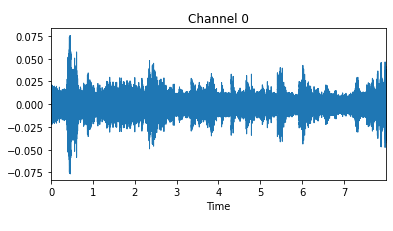

In [ ]:
audio = AudioTensor.create(speakers[2])
tfm = RemoveSilence(remove_type=RemoveType.Trim, threshold=20, pad_ms=50) # кажется в этой задаче бесполезно
tfm(audio).show()
#AudioTensor.create(tfm(y), sr).show()

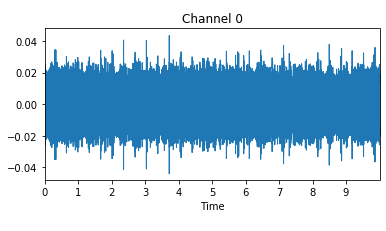

In [ ]:
audio = AudioTensor.create(speakers[1])
tfm = ResizeSignal(duration=10000) #duration im mlsec
tfm(audio).show()



In [ ]:
audio = AudioTensor.create(speakers[1])
tfm = ResizeSignal(duration=10000) #duration im mlsec
tfm(audio).show()

In [ ]:
y_new, sr_new = librosa.load(speakers[2], sr=16000) #use this
Audio(y_new, rate=sr_new)

In [ ]:
audio = AudioTensor.create(speakers[1])
tfm = Resample(28000) #duration im mlsec
audio2 = tfm(audio)
tmf2 = AudioToSpec.from_cfg(cfg)
audio3 = tmf2(audio2)
audio3.show() 
tmf3 = CropTime(446)
audio4 = tmf3(audio3)
audio4.show() 

NameError: ignored

In [ ]:
audio.shape, audio2.shape, audio3.shape, audio4.shape

(torch.Size([1, 1680000]),
 torch.Size([1, 1680000]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 128, 128]))

# Predict all classes

In [ ]:
dls.vocab

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
learn.dls.train_ds.items[12]

Path('/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples_long/2e40b2294_0_227.flac')

In [ ]:
learn.load("b3_step3")

In [ ]:
TEST_SAMPLES_AUDIO_ROOT = Path("/content/samples")

test_ds = auds.new(VAL_AUDIO_ROOT)
test_dl = learn.dls.test_dl(get_audio_files(TEST_SAMPLES_AUDIO_ROOT))
#print(test_dl.summary(TEST_TARGET_AUDIO_ROOT))
#test_probas, *_ = learn.tta(dl=test_dl, n=2, use_max=True)
test_probas, *_ = learn.tta(dl=test_dl, n=2, use_max=False, beta=0.5)

In [ ]:
learn.predict(Path("/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/val/00d442df7_9.flac"))

('0',
 tensor(0),
 tensor([9.9419e-01, 4.0612e-06, 2.1759e-06, 1.5235e-06, 2.5372e-04, 1.3985e-04,
         1.0884e-05, 1.1664e-05, 4.9186e-05, 6.9615e-07, 1.6545e-03, 1.8703e-06,
         1.3343e-05, 1.1704e-06, 7.1625e-06, 3.8790e-06, 8.6157e-05, 2.5122e-05,
         2.8939e-06, 7.6918e-06, 4.5211e-07, 6.0957e-07, 3.4889e-03, 4.4741e-05]))

In [ ]:
result=[]
for probas, fname in zip(test_probas, test_dl.items):
  print(fname)
  result.append([fname.stem.split("_")[0], fname.stem.split("_")[1], probas.numpy()])
res = pd.DataFrame(result, columns =["recording_id", "part_id", "probas"])
res["part_id"] = res["part_id"].astype(int)
res.to_csv("all_class_pred_2.csv", columns =["recording_id", "part_id", "probas"])

Выходные данные были обрезаны до нескольких последних строк (5000).
/content/samples/a81760ac4_14.flac
/content/samples/1dab35cfd_14.flac
/content/samples/d5723dd04_5.flac
/content/samples/85b951df8_11.flac
/content/samples/3dabe2366_0.flac
/content/samples/fc168108c_9.flac
/content/samples/7322733f3_7.flac
/content/samples/c84674265_8.flac
/content/samples/1f23d7fbd_8.flac
/content/samples/66d843421_10.flac
/content/samples/4de2b6553_5.flac
/content/samples/e12ff7cf3_4.flac
/content/samples/a2074e5a7_3.flac
/content/samples/570d295d0_4.flac
/content/samples/2a30fef72_4.flac
/content/samples/a77f548bd_3.flac
/content/samples/d3669f375_1.flac
/content/samples/34de5e276_12.flac
/content/samples/9ef5ebefb_2.flac
/content/samples/3779d8e9a_0.flac
/content/samples/5daa4a8b4_4.flac
/content/samples/273d502c3_12.flac
/content/samples/36fad96f1_7.flac
/content/samples/e3ec88f36_14.flac
/content/samples/ecf35cd2c_9.flac
/content/samples/052b35029_3.flac
/content/samples/ab1f1dcc5_11.flac
/conte

In [ ]:
subm = []
for n, row in res.sort_values(by="recording_id").groupby(by="recording_id"):
  a = np.stack(row["probas"].values)
  pred = np.concatenate([np.array(n).reshape(1),
                         np.array(dls.vocab[np.argmax(a.max(axis=0))]).reshape(1),
                         #np.where(a>0.7, a, 0).sum(axis=0)
                         a.max(axis=0)
                         ])
  subm.append(pred)
  #print(n)
  if n == "047a7c4bf":
    #print(row["probas"].max(axis=1))
    cls = np.stack(row["probas"].values).max(axis=0).argsort()
    #print(np.stack(row["probas"].values).argsort())
    #print(dls.vocab[cls[-1]], dls.vocab[cls[-2]], dls.vocab[cls[-3]])
#print(subm)
submission = pd.DataFrame(subm, columns=["recording_id"] + ["top_cat"] + ["s" + i for i in dls.vocab])
submission.head(10)

recording_id top_cat            s0  ...            s7            s8            s9
0    000316da7       3   0.080339335  ...  0.0049084057    0.00307606    0.06955744
1    003bc2cb2      16   0.011410619  ...    0.03468242   0.009249385   0.049980894
2    0061c037e       5    0.02906596  ...    0.25092372    0.11130914    0.08369193
3    010eb14d3       0     0.9974911  ...  0.0007145382    0.42986792  0.0031095147
4    011318064      14    0.14805093  ...   0.011185569  0.0028448026   0.028301142
5    01307e693       3  0.0010218327  ...      0.708761  0.0017894746   0.019515092
6    013bd8b85       3   0.012360034  ...   0.016121175  0.0069309757  0.0058757532
7    01812f522      17  0.0020803642  ...    0.00668539   0.004654103   0.010235799
8    019db5220      23   0.018642304  ...   0.012689218  0.0032237433    0.01525823
9    01bd97dd6      12    0.06701027  ...    0.15376411    0.08701427    0.05290997

[10 rows x 26 columns]

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(submission["top_cat"].values, val_df["species_id"].astype("str").values))
submission["top_cat"].values, val_df["species_id"].astype("str").values

0.845360824742268


(array(['14', '23', '12', '17', '10', '8', '0', '4', '15', '1', '6', '10',
        '11', '0', '7', '23', '13', '12', '16', '16', '0', '18', '19',
        '17', '11', '6', '3', '23', '14', '10', '11', '2', '4', '0', '12',
        '0', '6', '12', '15', '8', '23', '1', '16', '7', '22', '12', '23',
        '19', '7', '1', '12', '6', '21', '17', '11', '17', '13', '1', '2',
        '15', '2', '18', '3', '23', '13', '7', '18', '2', '20', '18', '15',
        '18', '23', '7', '17', '8', '9', '3', '1', '21', '10', '1', '11',
        '1', '14', '1', '7', '13', '0', '1', '3', '18', '13', '9', '19',
        '1', '0'], dtype=object),
 array(['14', '23', '12', '17', '10', '8', '0', '18', '15', '1', '6', '10',
        '7', '0', '11', '11', '13', '12', '16', '16', '0', '18', '19',
        '17', '7', '6', '3', '23', '14', '10', '11', '2', '4', '0', '12',
        '0', '3', '12', '15', '8', '10', '1', '16', '7', '22', '12', '23',
        '19', '7', '9', '12', '6', '21', '17', '17', '17', '13', '1', '2',
 

In [ ]:
val_df = df[:100].drop_duplicates(subset="recording_id")
val_df.shape

(97, 7)

In [ ]:
submission.drop(["top_cat"], axis=1, inplace=True)
submission.to_csv("subm_18_4.csv", columns=["recording_id"] + ["s" + str(i) for i in range(24)], index=False)

## Сравнение

In [ ]:
def final_lwlrap(scores, truth):
    #print(truth.shape, scores.shape)
    num_samples, num_classes = scores.shape
    scores = scores.cpu().numpy()
    gt = np.zeros((num_samples, num_classes))
    for n, i in enumerate(truth.cpu().numpy().astype(int)):
      gt[n, i] = 1
    gt = truth.cpu().numpy()
    assert gt.shape == scores.shape
    
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], gt[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits

    labels_per_class = np.sum(gt > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    #return per_class_lwlrap, weight_per_class
    return (per_class_lwlrap * weight_per_class).sum()
def search_max(x):
  maxx = x.max()
  return x.transform(lambda x: x if x == maxx else 0)


In [ ]:
f1 = pd.read_csv("/content/Modelssubmission_13_tpu_1.csv").sort_values(by="recording_id")
s1 = torch.Tensor(f1[f1.columns[1:]].apply(search_max, axis=1).to_numpy())
f2 = pd.read_csv("submission_13_tpu_2.csv").sort_values(by="recording_id")
s2 = torch.Tensor(f2[f2.columns[1:]].apply(search_max, axis=1).to_numpy())
f3 = pd.read_csv("subm_18_4.csv").sort_values(by="recording_id")
s3 = torch.Tensor(f3[f3.columns[1:]].apply(search_max, axis=1).to_numpy())
f4 = pd.read_csv("subm_18_3.csv").sort_values(by="recording_id")
s4 = torch.Tensor(f4[f4.columns[1:]].apply(search_max, axis=1).to_numpy())
final_lwlrap(s3, s1)

0.7017873342333254

## Вспомогательное


In [ ]:
class MaskFreq_fixed(SpectrogramTransform):
    """Google SpecAugment frequency masking from https://arxiv.org/abs/1904.08779."""

    def __init__(self, num_masks=1, size=20, start=None, val=None):
        self.num_masks = num_masks
        self.size = size
        self.start = start
        self.val = val

    def encodes(self, sg: AudioSpectrogram) -> AudioSpectrogram:
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:, None, None]
        mask_val = ifnone(self.val, channel_mean)
        if sg.ndim == 4:
          b, c, y, x = sg.shape
          # Position of the first mask
          start = ifnone(self.start, random.randint(0, y - self.size))
          for _ in range(self.num_masks):
              mask = torch.ones(self.size, x).cuda() * mask_val.cuda()
              mask = mask.view(b, c, self.size, x)
              #print("sg, mask:", sg.shape, mask.shape)
              if not 0 <= start <= y - self.size:
                  raise ValueError(
                      f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}"
                  )
              sg[:, :, start : start + self.size, :] = mask
              # Setting start position for next mask
              start = random.randint(0, y - self.size)
        else:
          c, y, x = sg.shape
          # Position of the first msk
          start = ifnone(self.start, random.randint(0, y - self.size))
          for _ in range(self.num_masks):
              mask = torch.ones(self.size, x) * mask_val
              if not 0 <= start <= y - self.size:
                  raise ValueError(
                      f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}"
                  )
              sg[:, start : start + self.size, :] = mask
              # Setting start position for next mask
              start = random.randint(0, y - self.size)
        return sg

resnet 34 fine tune 10, 5e-3

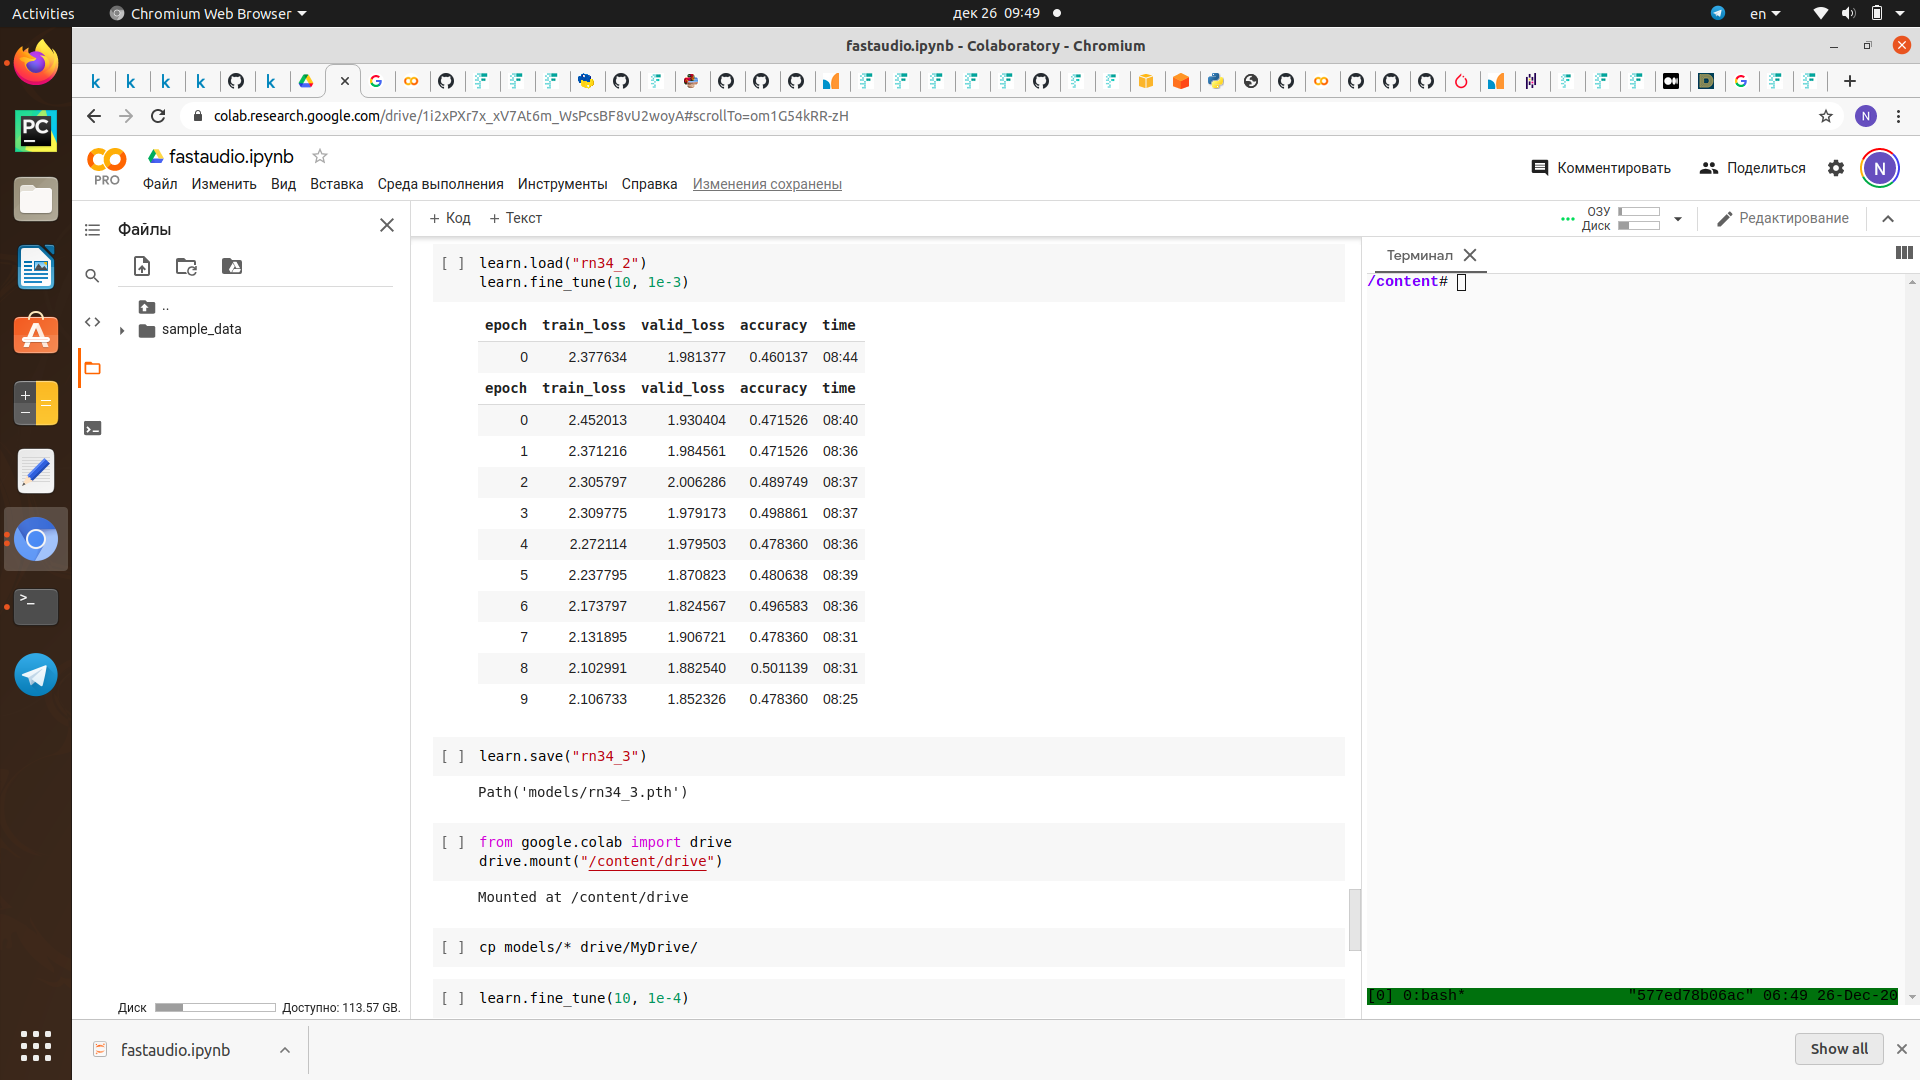

then resnet34 fit_one_cycle 20 1e-3
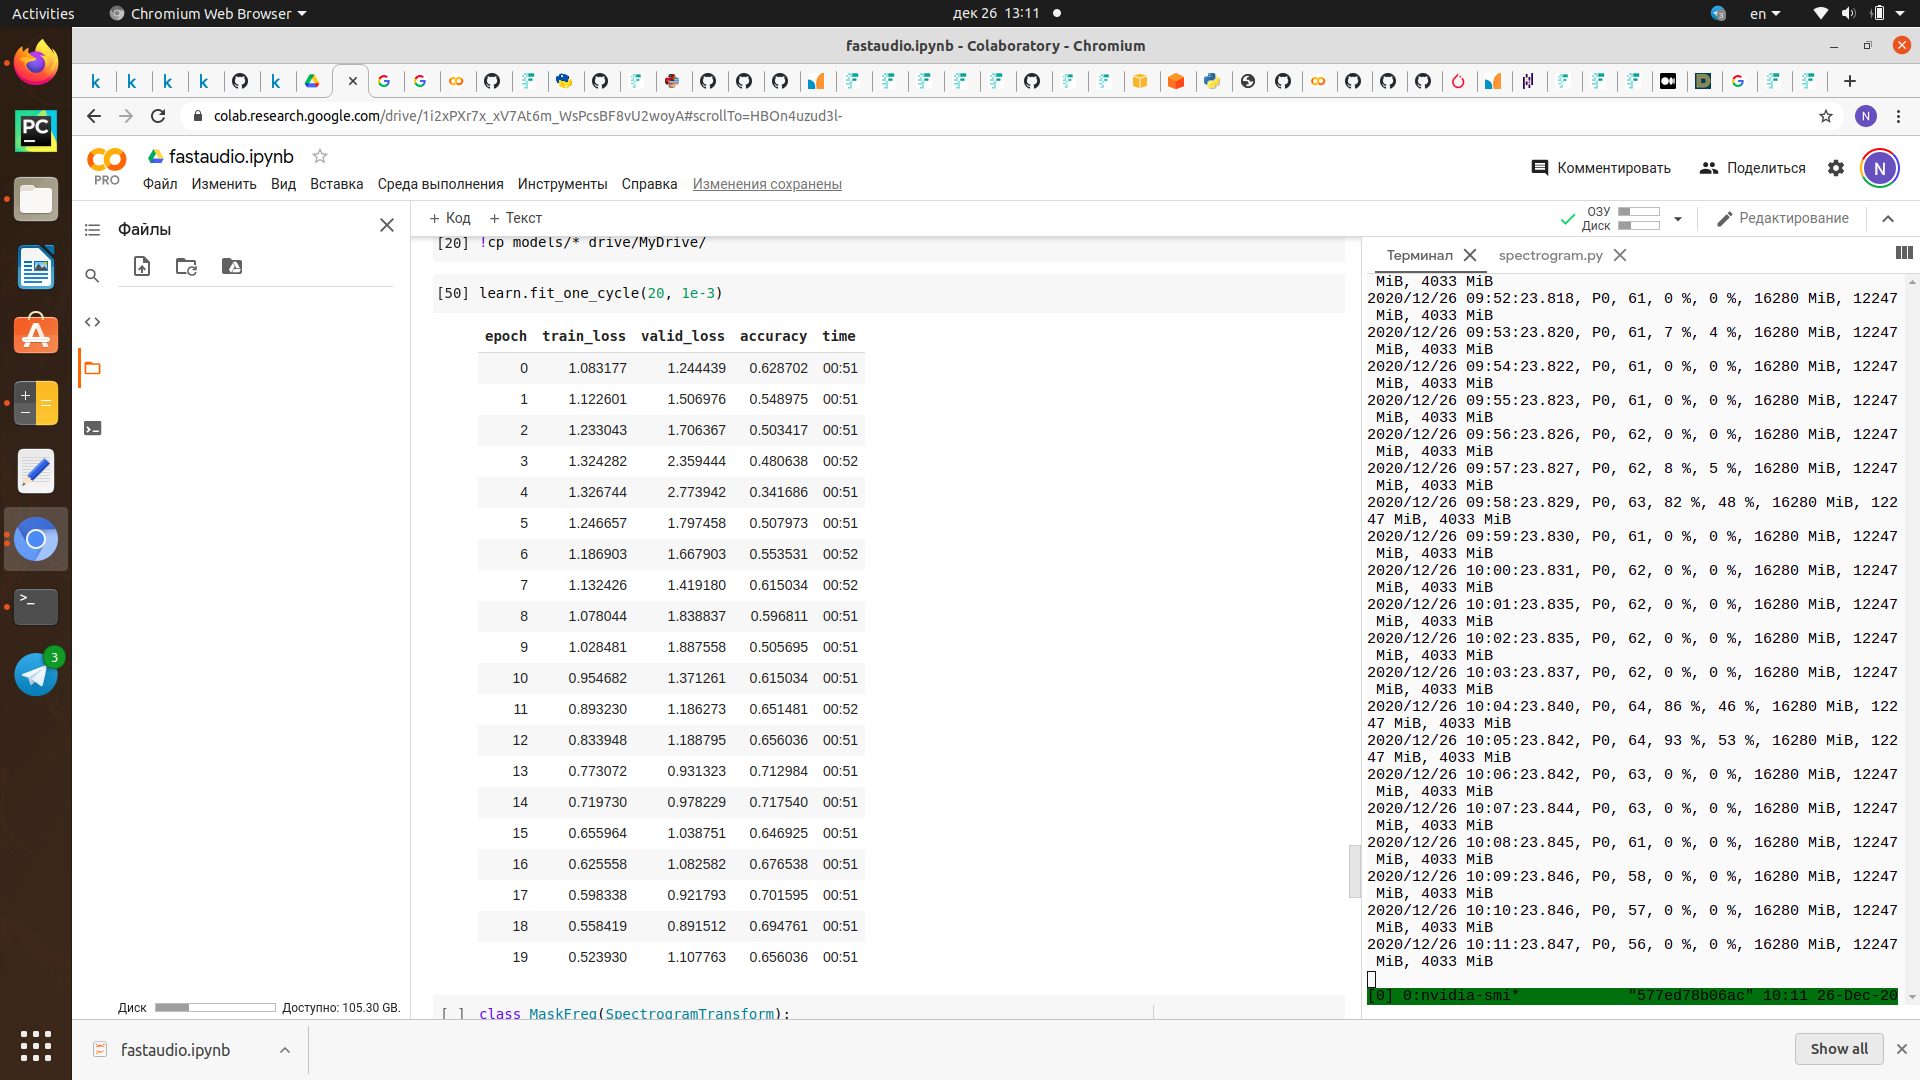

In [ ]:
!git clone https://github.com/DrHB/APTOS-2019-GOLD-MEDAL-SOLUTION.git

Cloning into 'APTOS-2019-GOLD-MEDAL-SOLUTION'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 102.24 MiB | 8.29 MiB/s, done.
Resolving deltas: 100% (120/120), done.
